In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [3]:
import deepmatcher as dm
import pandas as pd
from utils.explainer import generateExplanations

In [4]:
attributes =['title','manufacturer','price']

## Rnn model
We choose rnn model because it had strange rankings

In [5]:
rnn_model = dm.MatchingModel(attr_summarizer='rnn')
rnn_model.load_state('../../models/amazongoogle_rnn.pth')

In [6]:
testpos_nn_rnn = pd.read_csv('experiment_results/testpos_nn_rnn.csv')
negatives = pd.read_csv('../../Structured/Amazon-Google/negatives.csv')

In [7]:
critical_pos_rnn = {}
for att in attributes:
    critical_values = generateExplanations(testpos_nn_rnn,10,0.1,negatives,
                                           att,rnn_model,'../../Structured/Amazon-Google/positives.csv',1)
    critical_pos_rnn[att] = critical_values

===>  PREDICT Epoch 18
Finished Epoch 18 || Run Time:    0.7 | Load Time:    0.9 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00

===>  PREDICT Epoch 18
Finished Epoch 18 || Run Time:    0.5 | Load Time:    0.6 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00

===>  PREDICT Epoch 18
Finished Epoch 18 || Run Time:    0.4 | Load Time:    0.5 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00

===>  PREDICT Epoch 18
Finished Epoch 18 || Run Time:    0.5 | Load Time:    0.6 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00

===>  PREDICT Epoch 18
Finished Epoch 18 || Run Time:    0.5 | Load Time:    0.7 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00

===>  PREDICT Epoch 18
Finished Epoch 18 || Run Time:    0.4 | Load Time:    0.6 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00

===>  PREDICT Epoch 18
Finished Epoch 18 || Run Time:    0.5 | Load Time:    0.5 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00

===>  PREDICT

In [9]:
testneg_nn_rnn = pd.read_csv('experiment_results/testneg_nn_rnn.csv')
positives = pd.read_csv('../../Structured/Amazon-Google/positives.csv')

In [10]:
critical_neg_rnn = {}
for att in attributes:
    critical_values = generateExplanations(testneg_nn_rnn,10,0.1,positives,
                                           att,rnn_model,'../../Structured/Amazon-Google/negatives.csv',0)
    critical_pos_rnn[att] = critical_values

===>  PREDICT Epoch 18
Finished Epoch 18 || Run Time:    4.3 | Load Time:    7.0 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00

===>  PREDICT Epoch 18
Finished Epoch 18 || Run Time:    4.1 | Load Time:    5.9 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00

===>  PREDICT Epoch 18
Finished Epoch 18 || Run Time:    4.0 | Load Time:    4.9 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00

===>  PREDICT Epoch 18
Finished Epoch 18 || Run Time:    4.1 | Load Time:    5.5 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00

===>  PREDICT Epoch 18
Finished Epoch 18 || Run Time:    4.0 | Load Time:    5.2 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00

===>  PREDICT Epoch 18
Finished Epoch 18 || Run Time:    4.0 | Load Time:    5.0 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00

===>  PREDICT Epoch 18
Finished Epoch 18 || Run Time:    4.1 | Load Time:    5.9 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00

===>  PREDICT

In [20]:
critical_pos_rnn['price']

[('199.0', '199.95')]

In [13]:
def findCommonTokens(s_couple):
    s1_tokens = list(map(lambda s:s.lower(),s_couple[0].split()))
    s2_tokens = list(map(lambda s:s.lower(),s_couple[1].split()))
    return list(set(s1_tokens).intersection(s2_tokens))

In [16]:
common_tokens_title = []
for s_couple in critical_pos_rnn['title']:
    common_tokens_title.append(" ".join(findCommonTokens(s_couple)))

In [17]:
common_tokens_title

['windows microsoft',
 'upgrade microsoft',
 'mac ( )',
 'windows for software',
 '2007 microsoft',
 'adobe',
 'for microsoft',
 'windows microsoft',
 'design creative suite adobe',
 '2 wingnuts']

In [34]:
def testBias(model,testset_path,attribute,true_label,new_tokens):
    standard_test = dm.data.process_unlabeled(testset_path,model,ignore_columns=['id','label'])
    standard_pred = model.run_prediction(standard_test)
    test_df = pd.read_csv(testset_path)
    if true_label==1:
        true_positives = standard_pred[standard_pred.match_score>0.5].shape[0]
        test_df['ltable_'+attribute] = test_df['ltable_'+attribute]+" "+new_tokens[0]
        test_df['rtable_'+attribute] = test_df['rtable_'+attribute]+" "+new_tokens[1]
    else:
        true_positives = standard_pred[standard_pred.match_score <= 0.5].shape[0]
        test_df['ltable_'+attribute] = new_tokens[0]
        test_df['rtable_'+attribute] = new_tokens[1]
    test_df.to_csv('temp/new_test.csv',index=False)
    new_test = dm.data.process_unlabeled('temp/new_test.csv',model,ignore_columns=['id','label'])
    new_pred = model.run_prediction(new_test,output_attributes=True)
    if true_label==1:
        new_true_pos = new_pred[new_pred.match_score >0.5].shape[0]
    else:
        new_true_pos = new_pred[new_pred.match_score <=0.5].shape[0]
    print("Standard true positives: {} - New true positives:{}".format(true_positives,new_true_pos))
    if true_label ==1:
        return new_pred[new_pred.match_score <=0.5]
    else:
        return new_pred[new_pred.match_score >0.5]

In [38]:
fake_positives = testBias(rnn_model,'../../Structured/Amazon-Google/test_negatives.csv','price',0,('320.0', '320.0'))

===>  PREDICT Epoch 18
Finished Epoch 18 || Run Time:    0.8 | Load Time:    1.4 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00

===>  PREDICT Epoch 18
Finished Epoch 18 || Run Time:    0.8 | Load Time:    1.4 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00

Standard true positives: 1949 - New true positives:1708


In [37]:
fake_positives.to_csv('false_positives.csv',index=False)

In [57]:
testneg_nn_rnn = pd.read_csv('experiment_results/testneg_nn_rnn.csv')
positives = pd.read_csv('../../Structured/Amazon-Google/positives.csv')

In [60]:
critical_neg_rnn = {}
for att in attributes:
    critical_values = generateExplanations(testneg_nn_rnn,5,0.1,positives,
                                           att,rnn_model,'../../Structured/Amazon-Google/negatives.csv',0)
    critical_neg_rnn[att] = critical_values


Reading and processing data from "../../Structured/Amazon-Google/negatives.csv"
0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 20


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07

Reading and processing data from "temp/altered_test0.csv"


Finished Epoch 20 || Run Time:    3.1 | Load Time:    4.4 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 20


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06

Reading and processing data from "temp/altered_test1.csv"


Finished Epoch 20 || Run Time:    3.0 | Load Time:    3.8 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 20


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06

Reading and processing data from "temp/altered_test2.csv"


Finished Epoch 20 || Run Time:    3.0 | Load Time:    3.2 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 20


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06

Reading and processing data from "temp/altered_test3.csv"


Finished Epoch 20 || Run Time:    3.0 | Load Time:    3.6 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 20


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06

Reading and processing data from "temp/altered_test4.csv"


Finished Epoch 20 || Run Time:    3.0 | Load Time:    3.3 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 20


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06

Reading and processing data from "../../Structured/Amazon-Google/negatives.csv"


Finished Epoch 20 || Run Time:    3.0 | Load Time:    3.2 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 20


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07

Reading and processing data from "temp/altered_test0.csv"


Finished Epoch 20 || Run Time:    3.1 | Load Time:    4.4 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 20


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07

Reading and processing data from "temp/altered_test1.csv"


Finished Epoch 20 || Run Time:    3.1 | Load Time:    4.4 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 20


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07

Reading and processing data from "temp/altered_test2.csv"


Finished Epoch 20 || Run Time:    3.4 | Load Time:    4.5 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 20


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07

Reading and processing data from "temp/altered_test3.csv"


Finished Epoch 20 || Run Time:    3.2 | Load Time:    4.4 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 20


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07

Reading and processing data from "temp/altered_test4.csv"


Finished Epoch 20 || Run Time:    3.1 | Load Time:    4.2 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 20


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07

Reading and processing data from "../../Structured/Amazon-Google/negatives.csv"


Finished Epoch 20 || Run Time:    3.1 | Load Time:    4.3 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 20


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07

Reading and processing data from "temp/altered_test0.csv"


Finished Epoch 20 || Run Time:    3.1 | Load Time:    4.4 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 20


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07

Reading and processing data from "temp/altered_test1.csv"


Finished Epoch 20 || Run Time:    3.1 | Load Time:    4.4 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 20


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07

Reading and processing data from "temp/altered_test2.csv"


Finished Epoch 20 || Run Time:    3.1 | Load Time:    4.4 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 20


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07

Reading and processing data from "temp/altered_test3.csv"


Finished Epoch 20 || Run Time:    3.1 | Load Time:    4.4 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 20


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07

Reading and processing data from "temp/altered_test4.csv"


Finished Epoch 20 || Run Time:    3.1 | Load Time:    4.4 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 20


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


Finished Epoch 20 || Run Time:    3.1 | Load Time:    4.4 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



In [63]:
critical_neg_rnn['manufacturer']

[]

## New samples creation

In [5]:
from utils.newSamplesBuilder import buildNewSamples

In [ ]:
train_df = pd.read_csv('../../Structured/Amazon-Google/merged_train.csv')
train_pos = train_df[train_df.label==1].copy()

In [ ]:
train_pos['ltable_price'] = train_pos['ltable_price'].astype(str)
train_pos['rtable_price'] = train_pos['rtable_price'].astype(str)
new_positives_10perc_val0 = buildNewSamples(train_pos,'price',critical_pos_rnn['price'][0],int(train_pos.shape[0]/10),1)
new_positives_10perc_val1 = buildNewSamples(train_pos,'price',critical_pos_rnn['price'][1],int(train_pos.shape[0]/10),1)

In [ ]:
enriched_train_10perc = pd.concat([train_df,new_positives_10perc_val0,new_positives_10perc_val1])
enriched_train_10perc.to_csv('temp/enriched_train_10perc.csv',index=False)

In [ ]:
!cp ../../Structured/Amazon-Google/merged_valid.csv temp
!cp ../../Structured/Amazon-Google/merged_test.csv temp

In [8]:
train,validation,test = dm.data.process('temp',train='enriched_train_10perc.csv',validation='merged_valid.csv',
                                        test='merged_test.csv',left_prefix='ltable_',right_prefix='rtable_')

In [6]:
rnn_model_10perc = dm.MatchingModel(attr_summarizer='rnn')
rnn_model_10perc.run_train(train,validation,best_save_path='temp/amazongoogle_rnn_10perc.pth',batch_size=32,
                      pos_neg_ratio=10)

## New models evaluation

In [15]:
standard_rnn_model = dm.MatchingModel(attr_summarizer='rnn')
standard_rnn_model.load_state('../../models/amazongoogle_rnn.pth')

In [34]:
test = pd.read_csv('../../Structured/Amazon-Google/positives.csv')
test['ltable_price'] = 39.95
test['rtable_price'] = 20.99
test.to_csv('temp/price_test.csv',index=False)
test[test.label==1].shape

(1167, 8)

In [35]:
test_dm = dm.data.process_unlabeled('temp/price_test.csv',standard_rnn_model,ignore_columns=['id','label'])
standard_pred = standard_rnn_model.run_prediction(test_dm)
standard_pred[standard_pred.match_score >0.5].shape


Reading and processing data from "temp/price_test.csv"
0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 20


0% [███████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Finished Epoch 20 || Run Time:    0.4 | Load Time:    0.6 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



(835, 1)

In [36]:
test_dm_new = dm.data.process_unlabeled('temp/price_test.csv',rnn_model_10perc,ignore_columns=['id','label'])
new_pred = rnn_model_10perc.run_prediction(test_dm)
new_pred[new_pred.match_score >0.5].shape


Reading and processing data from "temp/price_test.csv"
0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 6


0% [███████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Finished Epoch 6 || Run Time:    0.4 | Load Time:    0.6 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



(1104, 1)

## Recompute Ri

In [48]:
from utils.intermediate_layer_extraction import return_layer_input
from utils.ri_calculator import computeRi

In [41]:
rnn_model_10perc = dm.MatchingModel(attr_summarizer='rnn')
rnn_model_10perc.load_state('temp/amazongoogle_rnn_10perc.pth')

In [42]:
testneg_classifier,testneg_ids = return_layer_input('../../Structured/Amazon-Google/'
                                                                         ,'test_negatives',128,rnn_model_10perc,
                                                                        rnn_model_10perc.classifier,device=-1)

In [43]:
testpos_classifier,testpos_ids = return_layer_input('../../Structured/Amazon-Google/',
                                                                  'test_positives',128,rnn_model,
                                                                  rnn_model.classifier,device=-1)

In [44]:
rnn_model_10perc = rnn_model_10perc.cuda()

In [45]:
classifier_len = len(testpos_classifier[0][0])
attribute_len = int(classifier_len/len(attributes))

In [49]:
positives_ri,pos_ri_norms = computeRi(rnn_model_10perc.classifier,
                                                    attributes,testpos_classifier,attribute_len,0)

100%|██████████| 106/106 [00:01<00:00, 55.63it/s]


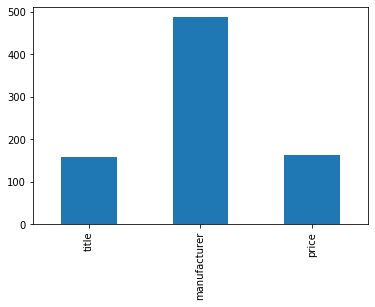

In [51]:
positives_variation_df = pd.DataFrame(data= pos_ri_norms,columns=attributes)
positives_variation_df.sum().plot.bar()

In [53]:
negatives_ri,neg_ri_norms = computeRi(rnn_model_10perc.classifier,
                                                    attributes,testneg_classifier,attribute_len,1)

100%|██████████| 128/128 [00:03<00:00, 28.91it/s]


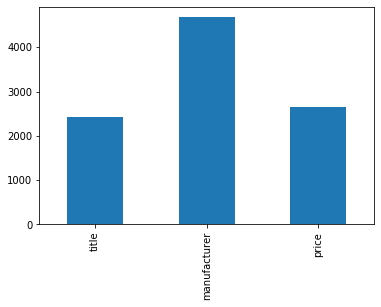

In [54]:
negatives_variation_df = pd.DataFrame(data= neg_ri_norms,columns=attributes)
negatives_variation_df.sum().plot.bar()